# Tutorial 02: Use customized PZ values and Priors

Author: Tianqing Zhang

You can easily change your default PZ parameter values and priors in your Fisher matrix, this tutorial will teach you how to do that. 

### First import the usual suspect and create a CCL cosmology

In [1]:
from fisherA2Z.fisher import Fisher

import pyccl as ccl
import matplotlib.pyplot as plt
import warnings
from fisherA2Z.fisher import Fisher, marginalize, SmailZ, Core, PhotozModel,plot_contours 

warnings.filterwarnings('ignore')

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.2666, 
                       Omega_b=0.049, 
                       h=0.6727, 
                       sigma8=0.831, 
                       n_s=0.9645, 
                       transfer_function='eisenstein_hu')


### To change your fiducial values, do this when you initialize your fisher forecast object, for example, we can run a Fisher forecast with default pz parameters in Graham2020+

In [3]:
graham = Fisher(cosmo, outliers=[0.1812, 0.0701, 0.0274, 0.0424, 0.379],
               zbias=[0.005, 0.00061, 0.00036, 0.00068, 0.00037],
               zvariance=[0.05+0.01854, 0.05+0.00891, 0.05+0.00738, 0.05+0.00936, 0.05+0.01043], 
                save_deriv='data/obj_deriv_graham.pkl', overwrite=False)
graham.process()

Making source pz
Making lens pz
Making fiducial c_ells
Getting covariance matrix
Building fisher matrix
Done


### The default priors for the PZ parameters are Gaussian priors with sigma = 0.1, we can change those by the `override_priors` functions

In [4]:
graham_custom_priors = Fisher(cosmo, outliers=[0.1812, 0.0701, 0.0274, 0.0424, 0.379],
               zbias=[0.005, 0.00061, 0.00036, 0.00068, 0.00037],
               zvariance=[0.05+0.01854, 0.05+0.00891, 0.05+0.00738, 0.05+0.00936, 0.05+0.01043], 
                save_deriv='data/obj_deriv_graham.pkl', overwrite=False)


In [5]:
# We build our customized prior in my_priors, 
# which correspond to priors if you have about 
# 5000 training galaxies for your photo-z

my_priors = {}
prior_bias_by_1plusz = [0.015, 0.009, 0.006, 0.006, 0.007]
prior_sigma_by_1plusz = [0.021, 0.014, 0.007, 0.005, 0.004]
prior_outlier = [0.011, 0.011, 0.011, 0.010, 0.008]

for i in range(5):
    my_priors[f'zbias{i+1}'] = prior_bias_by_1plusz[i]
    my_priors[f'zvariance{i+1}'] = prior_sigma_by_1plusz[i]
    my_priors[f'zoutlier{i+1}'] = prior_outlier[i]

graham_custom_priors.override_priors(my_priors)

0

In [9]:
#Let's check the updated 1/priors**2

graham_custom_priors.priors

{'sigma_8': 24.999999999999996,
 'omega_b': 111111.11111111111,
 'h': 64.0,
 'n_s': 24.999999999999996,
 'omega_m': 44.44444444444444,
 'w_0': 1.5624999999999998,
 'w_a': 0.5917159763313609,
 'zbias1': 4444.444444444444,
 'zbias2': 12345.679012345681,
 'zbias3': 27777.777777777777,
 'zbias4': 27777.777777777777,
 'zbias5': 20408.16326530612,
 'zvariance1': 2267.5736961451244,
 'zvariance2': 5102.04081632653,
 'zvariance3': 20408.16326530612,
 'zvariance4': 40000.0,
 'zvariance5': 62500.0,
 'zoutlier1': 8264.462809917357,
 'zoutlier2': 8264.462809917357,
 'zoutlier3': 8264.462809917357,
 'zoutlier4': 10000.0,
 'zoutlier5': 15625.0,
 'A0': 0.16,
 'beta': 1.0,
 'etal': 0.4444444444444444,
 'etah': 4.0,
 'gbias1': 1.2345679012345678,
 'gbias2': 1.2345679012345678,
 'gbias3': 1.2345679012345678,
 'gbias4': 1.2345679012345678,
 'gbias5': 1.2345679012345678,
 'gbias6': 1.2345679012345678,
 'gbias7': 1.2345679012345678,
 'gbias8': 1.2345679012345678,
 'gbias9': 1.2345679012345678,
 'gbias10': 

In [7]:
graham_custom_priors.process()

Making source pz
Making lens pz
Making fiducial c_ells
Getting covariance matrix
Building fisher matrix
Done


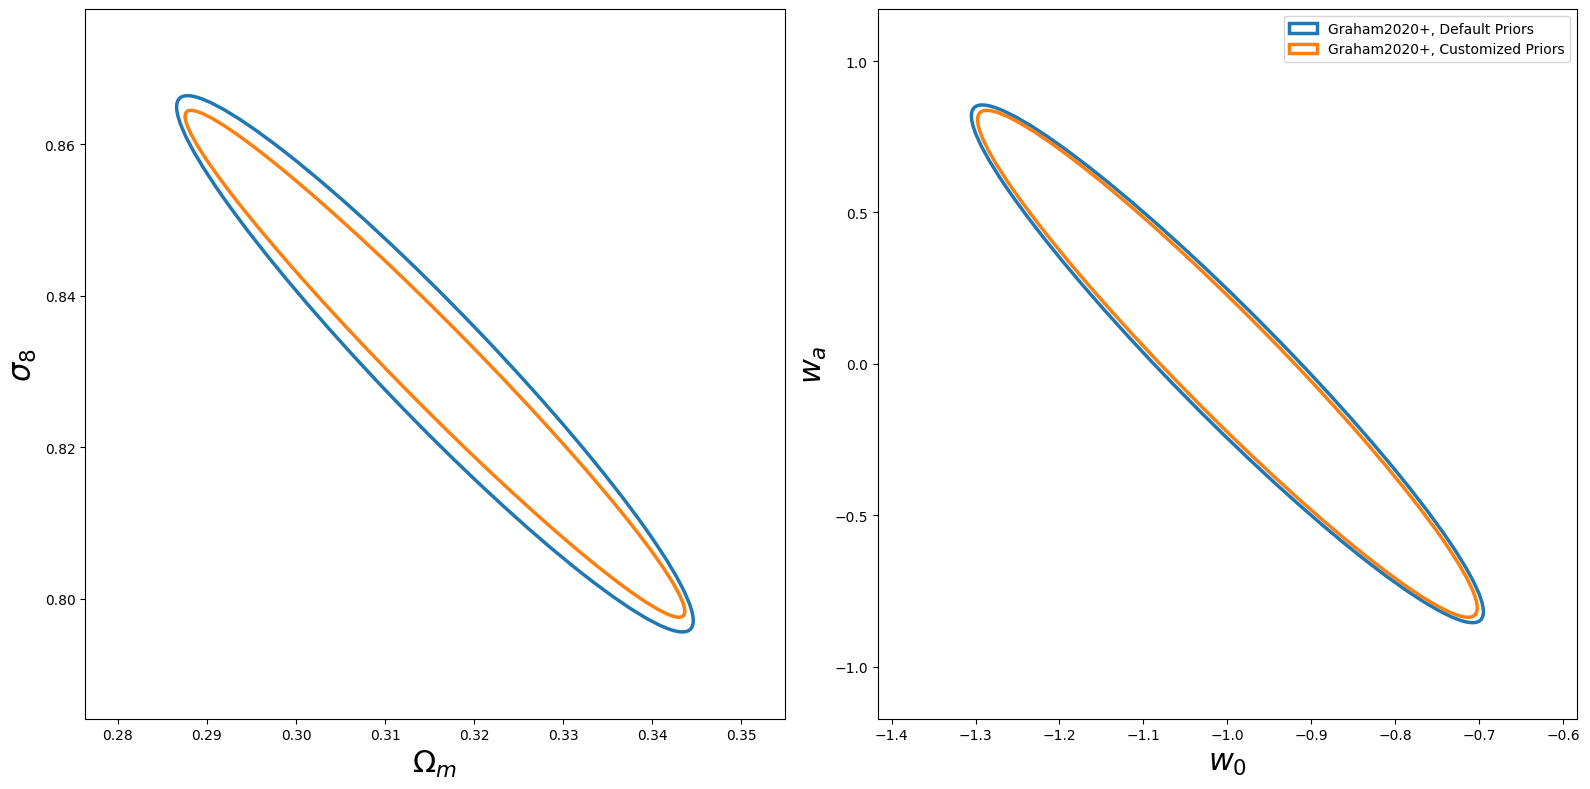

In [10]:
sizes = {}
fisher_matrix_list = []
fig, ax = plt.subplots(1, 2, figsize = (16,8))
for paramset in [[['omega_m', 'sigma_8'], ['w_0', 'w_a']]]:
    
    for j, params in enumerate(paramset):
        
        tab10 = plt.cm.get_cmap('tab10')
        colors = [tab10(i) for i in range(tab10.N)]
        arg = graham
        labels = ['Graham2020+, Default Priors',  'Graham2020+, Customized Priors' ]
        line_styles = ['-', '-', '--', ]
        es = []
        for matrix, label, line_style, color in zip([graham.fisher, graham_custom_priors.fisher], labels, line_styles, colors[:3]):

            fid=(arg.vals[params[0]], arg.vals[params[1]])
            if label == 'biased':
                fid = (fid[0] + para_bias[params[0]], fid[1] + para_bias[params[1]])
            this_fisher = marginalize(matrix, 
                            arg.param_order.index(params[0]), 
                            arg.param_order.index(params[1]))
            fisher_matrix_list.append(this_fisher)
            e, xlim, ylim, size = plot_contours(
                this_fisher,
                sigmas=2, fid=fid
                )
            sizes[label] = size
                    
            e.set_label(label)
            e.set_linestyle(line_style)
            e.set_facecolor('none')
            e.set_edgecolor(color)
            e.set_linewidth(2.5)
            e.set_alpha(1)
            
            es.append(e)
            ax[j].add_artist(e)
            #limnew = 1*max(abs(para_bias[params[0]]), abs(para_bias[params[1]]))
            xlim = (arg.vals[params[0]] - 1.4* xlim, arg.vals[params[0]] + 1.4* xlim)
            ylim = (arg.vals[params[1]] - 1.4* ylim, arg.vals[params[1]] + 1.4* ylim)
            ax[j].set_xlim((xlim))
            ax[j].set_ylim((ylim))
            ax[j].set_xlabel(arg.param_labels[arg.param_order.index(params[0])], fontsize = 22)
            ax[j].set_ylabel(arg.param_labels[arg.param_order.index(params[1])], fontsize = 22)
            plt.tight_layout()
    ax[j].legend(handles=es)

        